In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor


pd.set_option('display.max_colwidth', 355)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('datasets/b3_stocks_1994_2020.csv')
#df = pd.read_csv('../b3data/b3_stocks_1994_2020.csv')

## IBOV Ações - Exploração inicial

In [3]:
df.head()

,datetime,ticker,open,close,high,low,volume
0,1994-07-04,ACE 3,48.00,48.00,48.00,47.00,46550.0
1,1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
2,1994-07-04,ALP 4,131.00,131.00,131.00,131.00,6550.0
3,1994-07-04,IBP 6,600.00,600.00,600.00,600.00,7800.0
4,1994-07-04,AQT 4,0.89,0.99,0.99,0.85,13137.0


In [4]:
df.shape

(1883203, 7)

## Tratamento dos dados

In [5]:
# Convertendo string para datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
# Removendo coluna não utilizada
# df = df.drop(['volume'], axis=1)

### Criação de novas features

In [7]:
# Variação diária em porcentagem 
df['delta_open'] = df.apply(lambda x: (abs(x['open'] - x['close']) / x['open']), axis=1)

In [8]:
# Indica se a variação foi positiva, negativa ou zero
def calc_delta_side(row):
    delta = row['open'] - row['close']
    if delta > 0:
        return 1
    elif delta == 0:
        return 0
    else:
        return -1

df['delta_side'] = df.apply(lambda row: calc_delta_side(row), axis=1)

**Coluna delta_high faz sentido??? (high - low)**

### Removendo dados que não fazem sentido
com por exemplo, preço máximo menor do que o preço de abertura

In [9]:
# Muita low e high com muita variação mas close e open próximos
df.loc[df['delta_open'] > 10].head(10)

,datetime,ticker,open,close,high,low,volume,delta_open,delta_side
122258,1996-08-14,LAE 4,0.05,0.59,0.59,0.05,4.92,10.800000,-1
582487,2005-03-18,TPEC11B,1.00,33.00,1.00,1.00,1.00,32.000000,-1
587314,2005-04-20,ENMA3B,0.39,20.00,0.39,0.39,197501.46,50.282051,-1
786027,2008-03-13,AMCE3,0.22,3.26,3.26,0.22,103604.00,13.818182,-1


#### Seriam esses dois dados ruido? (high = 1 / close = 33)

In [10]:
df = df.loc[(df['high'] >= df['open']) & (df['high'] >= df['close'])]
df = df.loc[(df['open'] >= df['low']) & (df['close'] >= df['low'])]

df = df.loc[(df['high'] >= df['low'])]

df.shape

(1882841, 9)

### Plotando distribuições

In [11]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,open,close,high,low,volume,delta_open,delta_side
count,1882841.00,1882841.00,1882841.00,1882841.00,1882841.00,1882841.00,1882841.00
mean,68.08,68.21,68.76,67.47,16686024.33,0.02,0.01
std,1689.92,1695.21,1700.11,1683.75,102644019.76,0.04,0.86
min,0.01,0.01,0.01,0.01,0.00,0.00,-1.00
25%,3.96,3.96,4.00,3.89,18013.00,0.00,-1.00
50%,13.69,13.70,13.91,13.45,252842.00,0.01,0.00
75%,36.67,36.70,37.10,36.05,4796632.00,0.02,1.00
max,1297776.47,1297776.47,1297776.47,1297776.47,42983799660.00,13.82,1.00


<AxesSubplot:xlabel='delta_open'>

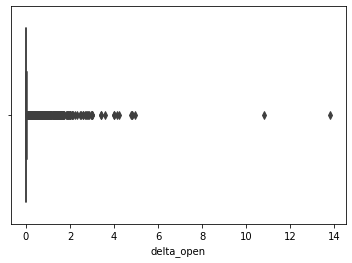

In [12]:
sns.boxplot(x=df['delta_open'])
# Esses pontos são possíveis outliers???

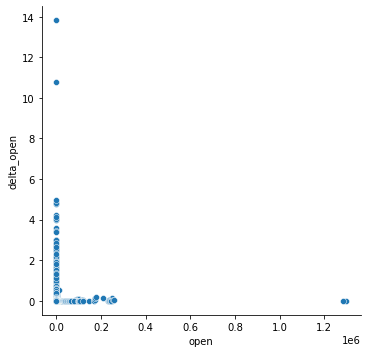

In [13]:
# Cortando uma parte dos dados para ver o gráfico com "zoom"
sns.relplot(x="open", y="delta_open", data=df)

### Normalizando valores

**Normalizar antes ou depois de criar as feature?**

In [14]:
# Normalizando os valores com MinMaxScaler
# df[['open', 'close', 'low', 'high', 'delta_open']] = MinMaxScaler().fit_transform(df[['open', 'close', 'low', 'high', 'delta_open']])

In [15]:
# Normalizando os valores usando normalização logaritmica
# df[['open', 'close', 'low', 'high', 'delta_open']] = np.log(df[['open', 'close', 'low', 'high', 'delta_open']])

### Cortando uma parte dos dados para ver o gráfico com "zoom"

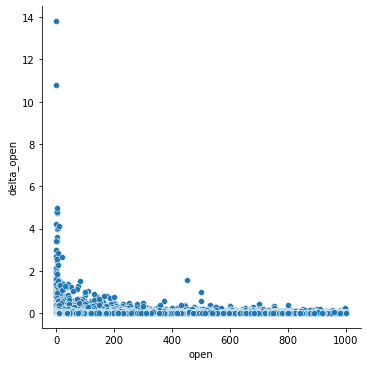

In [16]:
sns.relplot(x="open", y="delta_open", data=df.loc[(df['delta_open'] < 1000) & (df['open'] < 1000)])

## Usaremos dados depois de 95 por causa do plano real
Não temos a informação de como foi realizada a conversão da moeda e o ano de 94 possui muitas observações destoantes

In [17]:
df = df.loc[df['datetime'] > '1995-01-01']

## Vamos usar apenas dados desse seculo
Ao procurar muitas das ações listadas no dataset não encontramos informações

In [18]:
df = df.loc[df['datetime'] > '2000-01-01']

#### Entendendo ações da amazon caindo bruscamente

<AxesSubplot:xlabel='datetime', ylabel='close'>

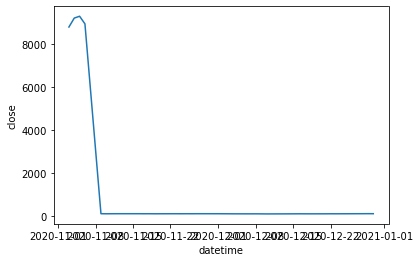

In [19]:
sns.lineplot(x='datetime', y='close', data=df.loc[(df['ticker'] == 'AMZO34') & (df['datetime'] > '2020-11-01') & (df['datetime'] > '2020-11-01')])

In [20]:
# Analisando alguns dados para entender o motivo da variação brusca
df.loc[(df['ticker'] == 'AMZO34') & (df['datetime'] > '2020-11-01') & (df['datetime'] > '2020-11-01')]

,datetime,ticker,open,close,high,low,volume,delta_open,delta_side
1854244,2020-11-03,AMZO34,8638.99,8779.45,8840.00,8444.44,14952140.22,0.016259,-1
1854245,2020-11-04,AMZO34,8951.00,9194.65,9194.65,8951.00,9608634.26,0.027220,-1
1854246,2020-11-05,AMZO34,9207.00,9280.00,9350.00,9164.90,7387944.57,0.007929,-1
1854247,2020-11-06,AMZO34,9280.00,8926.50,9280.00,8870.00,12508258.30,0.038093,1
1854248,2020-11-09,AMZO34,113.71,108.81,117.95,105.96,29284445.04,0.043092,1
1854249,2020-11-10,AMZO34,106.08,105.47,107.27,103.30,30493277.04,0.005750,1
1859273,2020-11-11,AMZO34,106.29,107.55,108.05,104.85,20231314.93,0.011854,-1
1859274,2020-11-12,AMZO34,107.92,108.60,109.61,107.15,12690454.53,0.006301,-1
1859275,2020-11-13,AMZO34,108.66,108.88,110.11,107.78,11766562.93,0.002025,-1
1859276,2020-11-16,AMZO34,107.32,108.88,109.06,106.02,9451368.82,0.014536,-1


#### Provavelmente reindexação (1 ação virou 10 com 1/10 do preço)

### LOF

In [21]:
def get_LOF_scores(df, n_neighbors=10, contamination=0.05):
    np.random.seed(42)

    # fit the model for outlier detection (default)
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(df)

    X_scores = clf.negative_outlier_factor_
    
    output_df = df.copy()
    output_df['LOF_score'] = X_scores
    output_df['LOF_predictions'] = y_pred
    
    return output_df

In [22]:
def show_2D_outliers(df, x, y, scores, title = ''):

    normalized = (df[scores].max() - df[scores]) / (df[scores].max() - df[scores].min())
    
    t = "Outlier Scores"
    if title: t=t+": "+title
    
    fig, ax = plt.subplots(figsize=(8, 6))

    plt.title(t)
    plt.scatter(x=x, y=y, color='k', s=3., label='Data points', data=df)
    # plot circles with radius proportional to the outlier scores

    plt.scatter(x=x, y=y, s=1000 * normalized, edgecolors='r',
                facecolors='none', label='Outlier scores', data=df)
    plt.axis('tight')
    # plt.xlim((-5, 5))
    # plt.ylim((-5, 5))
    # plt.xlabel("prediction errors: %d" % (n_errors))
    legend = plt.legend(loc='upper right')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()

### Aplicando o algoritmo para uma faixa muito densa do dataset

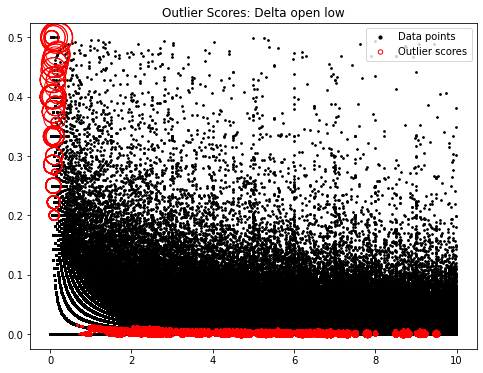

In [23]:
df_low = df[['open', 'delta_open']]
df_low = df_low.loc[(df_low['open'] < 10) & (df_low['delta_open'] < 0.5)]
scores_low = get_LOF_scores(df_low, n_neighbors=300, contamination=0.5)

show_2D_outliers(scores_low, x = 'open', y = 'delta_open', scores = 'LOF_score', title = 'Delta open low')

#### Acreditamos que nesse caso a visualização seja ruim pois alguns circulos ficam grandes o suficiente para ficar fora do gráfico

### Aplicando o algoritmo para uma faixa pouco densa do dataset

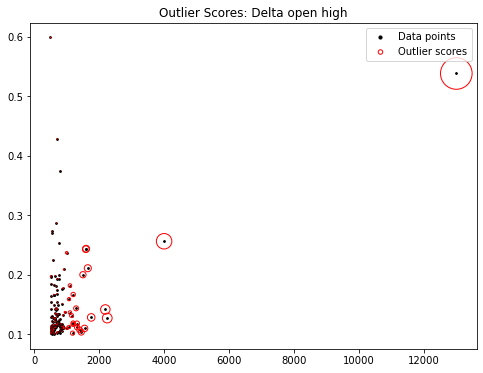

In [24]:
df_high = df[['open', 'delta_open']]
df_high = df_high.loc[(df_high['open'] > 500) & (df_high['delta_open'] > 0.1)]
scores_high = get_LOF_scores(df_high, n_neighbors=100, contamination=0.3)

show_2D_outliers(scores_high, x = 'open', y = 'delta_open', scores = 'LOF_score', title = 'Delta open high')

**Acreditamos que nesse caso a visualização seja mais efetiva, porém não sabemos como realizar transformações no dataset para chegar numa visualização coerente **

### Resultados

- Maior problema identificado: disparidade no preço das ações (algumas centavos outras milhares de reais). Como tratar? - Normalização utilizando escala logaritmica???

- Sem resultados satisfatórios
- Visualização não é boa nesse caso
- Quais outras transformações podem ser feitas ou visualizações exploradas?
- Como tratar a disparidade entre os preços das ações?

# Em busca dos Circuit Breakers

### Criando novas colunas

Meta:
- quantas acoes cairam
- quantas acoes subiram
- media da variacao
- media da variacao das 10+
- desvio padrao da variacao
- media do volume
- dia

Getting the most important ibovespa stocks

In [25]:
ibov_composition = pd.read_csv('datasets/IBOVDia_08-16-21.csv')
ibov_composition.reset_index(inplace=True)
ibov_composition.sort_values('Theoretical Quantity', ascending=False, inplace=True)
top_15 = ibov_composition[1:16]['index'].to_list()

In [26]:
# Quantos porcento as 15 maiores ações representam no indice IBOVESPA
ibov_composition[1:16]['Theoretical Quantity'].sum()

59.008

Creating the daily aggregation

In [27]:
def how_many_went_up(series):
    return series[series == 1].shape[0] / series.shape[0]

def how_many_went_down(series):
    return series[series == -1].shape[0] / series.shape[0]

In [28]:
df_daily = df.groupby('datetime').agg(
    {
        'delta_open':['mean','std'],
        'volume': 'mean',
        'delta_side': [how_many_went_up, how_many_went_down]}
)

Renaming the columns

In [29]:
df_daily.columns = df_daily.columns.to_flat_index()
df_daily.rename(
    columns={
        ('delta_open', 'mean'): 'variation_mean',
        ('delta_open', 'std'): 'variation_std',
        ('volume', 'mean'): 'volume_mean',
        ('delta_side', 'how_many_went_up'): 'up_count',
        ('delta_side', 'how_many_went_down'): 'down_count',
    }, inplace = True
)

Getting the mean variation of the 15 most important stocks

In [30]:
df_top_15 = df.loc[df['ticker'].isin(top_15)]
daily_df_top_15 = df_top_15.groupby('datetime').agg({'delta_open': 'mean'})
daily_df_top_15.rename(columns= {'delta_open': 'top_15_variation_mean'}, inplace = True)

joining if the df_daily dataset

In [31]:
df_daily = pd.merge(df_daily, daily_df_top_15, on='datetime')
df_daily.reset_index(inplace=True)

In [32]:
df_daily

,datetime,variation_mean,variation_std,volume_mean,up_count,down_count,top_15_variation_mean
0,2000-01-03,0.036323,0.099874,2.738140e+06,0.393805,0.336283,0.016457
1,2000-01-04,0.036183,0.067482,2.893430e+06,0.551724,0.137931,0.041053
2,2000-01-05,0.034812,0.052151,4.228136e+06,0.138211,0.589431,0.028798
3,2000-01-06,0.029942,0.070373,3.246791e+06,0.323741,0.359712,0.010690
4,2000-01-07,0.025156,0.045434,2.368776e+06,0.293478,0.326087,0.014791
...,...,...,...,...,...,...,...
5193,2020-12-22,0.014322,0.028736,2.959592e+07,0.464236,0.347826,0.011171
5194,2020-12-23,0.015095,0.019468,2.784140e+07,0.277465,0.525352,0.014803
5195,2020-12-28,0.013466,0.020737,2.554248e+07,0.379795,0.457801,0.009518
5196,2020-12-29,0.013948,0.051182,2.469294e+07,0.465517,0.364721,0.007166


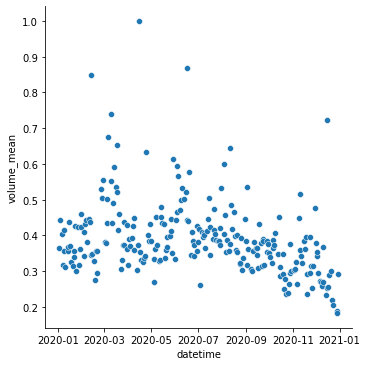

In [33]:
# Normalizing volume mean
df_daily['volume_mean'] = MinMaxScaler().fit_transform(df_daily[['volume_mean']])
sns.relplot(x="datetime", y="volume_mean", data=df_daily.loc[df_daily['datetime'] > '2020'])

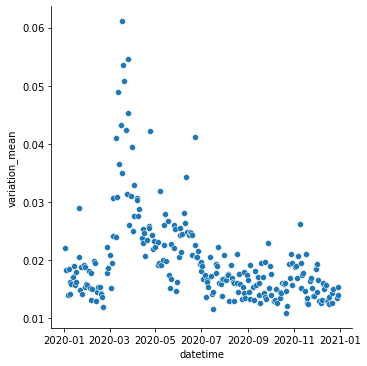

In [34]:
sns.relplot(x="datetime", y="variation_mean", data=df_daily.loc[df_daily['datetime'] > '2020'])

<AxesSubplot:xlabel='datetime', ylabel='variation_mean'>

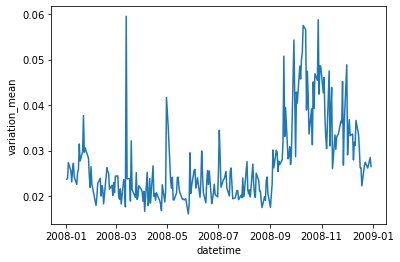

In [35]:
sns.lineplot(x="datetime", y="variation_mean", data=df_daily.loc[(df_daily['datetime'] > '2008') & (df_daily['datetime'] < '2009')])

### Outlier Detection

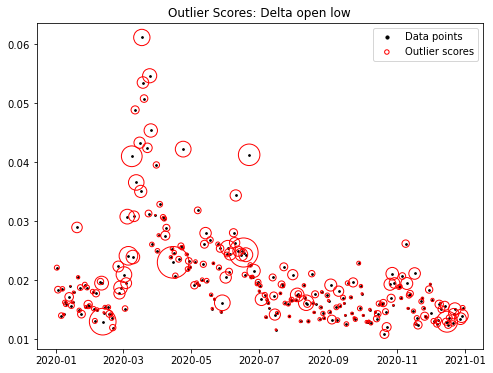

In [36]:
df_2020 = df_daily.loc[df_daily['datetime'] > '2020'].set_index('datetime')
df_2020_lof = get_LOF_scores(df_2020, n_neighbors=40, contamination=0.5)

# Para plotar o grafico, o datetime não pode ser a index do dataset
df_2020_lof.reset_index(inplace=True)
show_2D_outliers(df_2020_lof, x = 'datetime', y = 'variation_mean', scores = 'LOF_score', title = 'Delta open low')

**Removendo o dado de volume**

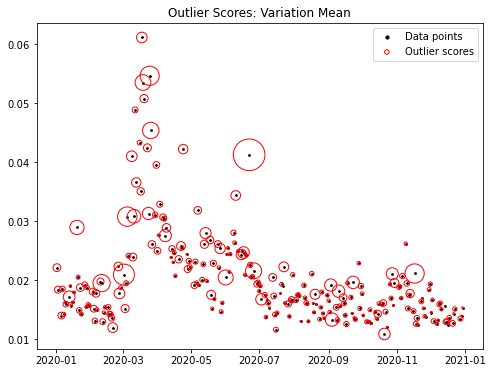

In [37]:
df_2020_lof = get_LOF_scores(df_2020.drop(columns=['volume_mean']), n_neighbors=40, contamination=0.5)

df_2020_lof.reset_index(inplace=True)
show_2D_outliers(df_2020_lof, x = 'datetime', y = 'variation_mean', scores = 'LOF_score', title = 'Variation Mean')

**Plotando para 2008**

In [38]:
# df_2020 = df_daily.loc[(df_daily['datetime'] > '2008') & (df_daily['datetime'] < '2009')].set_index('datetime')
# scores_low = get_LOF_scores(df_2020, n_neighbors=100, contamination=0.5)

# # Para plotar o grafico, o datetime não pode ser a index do dataset
# scores_low.reset_index(inplace=True)
# show_2D_outliers(scores_low, x = 'datetime', y = 'variation_mean', scores = 'LOF_score', title = 'Delta open low')

## O dataset utilizado será o de 2020 sem os dados de volume

In [39]:
df_2020_lof.mean()

/var/folders/fq/0s3sdjd50r79swwqd52gm5xh0000gn/T/ipykernel_39281/2459732842.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_2020_lof.mean()


variation_mean           0.019992
variation_std            0.030338
up_count                 0.431852
down_count               0.384892
top_15_variation_mean    0.019375
LOF_score               -1.081476
LOF_predictions          0.004016
dtype: float64

**Linha com maior LOF_score que não foi considerada Outlier**

In [40]:
df_2020_lof.loc[df_2020_lof['LOF_predictions'] == 1].sort_values(by=['LOF_score']).head(1)

,datetime,variation_mean,variation_std,up_count,down_count,top_15_variation_mean,LOF_score,LOF_predictions
209,2020-11-03,0.018812,0.025185,0.364307,0.458702,0.016967,-1.015093,1


In [41]:
df_2020_lof.sort_values(by=['LOF_score']).head(10)

,datetime,variation_mean,variation_std,up_count,down_count,top_15_variation_mean,LOF_score,LOF_predictions
116,2020-06-22,0.041245,0.219615,0.467230,0.338266,0.022935,-3.433015,-1
40,2020-03-02,0.020938,0.025288,0.116667,0.626667,0.026662,-2.047116,-1
43,2020-03-05,0.030761,0.031469,0.689300,0.078189,0.037290,-1.894072,-1
219,2020-11-17,0.021122,0.133953,0.404834,0.419940,0.015173,-1.877098,-1
57,2020-03-25,0.054643,0.064407,0.150362,0.605072,0.078893,-1.867313,-1
28,2020-02-11,0.019489,0.029532,0.163170,0.629371,0.015581,-1.698681,-1
58,2020-03-26,0.045365,0.055690,0.164032,0.602767,0.028178,-1.628324,-1
120,2020-06-26,0.021564,0.025279,0.683333,0.120833,0.015182,-1.596467,-1
53,2020-03-19,0.053499,0.068972,0.194107,0.519931,0.079064,-1.570709,-1
102,2020-06-01,0.020451,0.032411,0.167925,0.573585,0.017839,-1.517004,-1


**z-score for all columns and cut the 10+**

In [54]:
df_top_10_zscore = df_2020_lof.sort_values(by=['LOF_score'])
df_top_10_zscore = df_top_10_zscore.drop(columns=['LOF_score', 'LOF_predictions'])
df_top_10_zscore = df_top_10_zscore.set_index('datetime').apply(zscore).head(10)

df_top_10_zscore = df_top_10_zscore.abs()
df_top_10_zscore

,variation_mean,variation_std,up_count,down_count,top_15_variation_mean
datetime,,,,,
2020-06-22,2.673,10.672,0.286,0.377,0.334
2020-03-02,0.119,0.285,2.547,1.957,0.684
2020-03-05,1.355,0.064,2.080,2.482,1.682
2020-11-17,0.142,5.842,0.218,0.284,0.395
2020-03-25,4.358,1.921,2.275,1.782,5.590
2020-02-11,0.063,0.045,2.171,1.979,0.356
2020-03-26,3.191,1.430,2.164,1.763,0.827
2020-06-26,0.198,0.285,2.032,2.137,0.394
2020-03-19,4.215,2.178,1.921,1.093,5.606


<AxesSubplot:ylabel='datetime'>

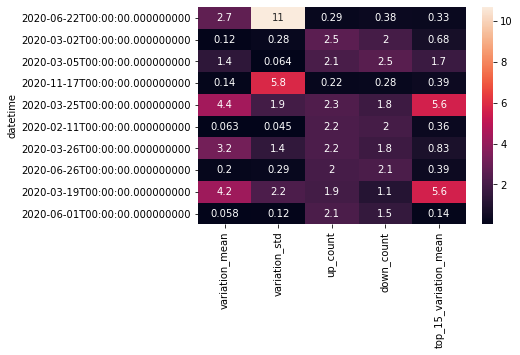

In [55]:
sns.heatmap(df_top_10_zscore, annot=True)

In [56]:
df_top_10_zscore.sum(axis=1).sort_values()

datetime
2020-06-01    3.979
2020-02-11    4.615
2020-06-26    5.046
2020-03-02    5.592
2020-11-17    6.881
2020-03-05    7.663
2020-03-26    9.375
2020-06-22   14.343
2020-03-19   15.013
2020-03-25   15.925
dtype: float64

In [57]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_top_10_zscore.sum().sort_values()

down_count              15.381
top_15_variation_mean   16.012
variation_mean          16.372
up_count                17.827
variation_std           22.840
dtype: float64

**Usando apenas as colunas que mais variam**

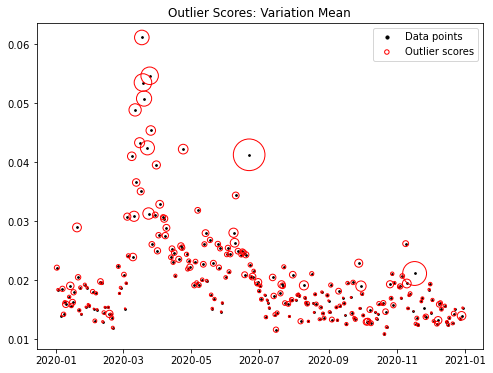

In [58]:
df_2020.reset_index(inplace=True)
df_2020_short = df_2020[['datetime', 'variation_std', 'variation_mean', 'top_15_variation_mean']].set_index('datetime')
df_2020_lof_short = get_LOF_scores(df_2020_short, n_neighbors=40, contamination=0.5)

df_2020_lof_short.reset_index(inplace=True)
show_2D_outliers(df_2020_lof_short, x = 'datetime', y = 'variation_mean', scores = 'LOF_score', title = 'Variation Mean')

In [59]:
df_top_10_short = df_2020_lof_short.sort_values(by='LOF_score').head(10)
df_top_10_short.head(10)

,datetime,variation_std,variation_mean,top_15_variation_mean,LOF_score,LOF_predictions
116,2020-06-22,0.220,0.041,0.023,-8.847,-1
219,2020-11-17,0.134,0.021,0.015,-5.445,-1
53,2020-03-19,0.069,0.053,0.079,-3.378,-1
57,2020-03-25,0.064,0.055,0.079,-3.361,-1
54,2020-03-20,0.049,0.051,0.068,-2.771,-1
52,2020-03-18,0.073,0.061,0.046,-2.622,-1
55,2020-03-23,0.046,0.042,0.065,-2.518,-1
48,2020-03-12,0.052,0.049,0.052,-2.143,-1
56,2020-03-24,0.039,0.031,0.055,-1.976,-1
187,2020-09-30,0.064,0.019,0.011,-1.785,-1


**Quais os valores que aparecem na primeira scoragem LOF que não aparecem no recorte**

In [60]:
df_top_10 = df_2020_lof.sort_values(by=['LOF_score']).head(10)['datetime']
set(df_top_10.to_list()) - set(df_top_10_short['datetime'].to_list())

{Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-03-02 00:00:00'),
 Timestamp('2020-03-05 00:00:00'),
 Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-06-26 00:00:00')}

**heatmap do recorte**

In [61]:
df_top_10_zscore_short = df_2020_lof_short.sort_values(by=['LOF_score'])
df_top_10_zscore_short = df_top_10_zscore_short.drop(columns=['LOF_score', 'LOF_predictions'])
df_top_10_zscore_short = df_top_10_zscore_short.set_index('datetime').apply(zscore).head(10)

df_top_10_zscore_short = df_top_10_zscore_short.abs()
df_top_10_zscore_short

,variation_std,variation_mean,top_15_variation_mean
datetime,,,
2020-06-22,10.672,2.673,0.334
2020-11-17,5.842,0.142,0.395
2020-03-19,2.178,4.215,5.606
2020-03-25,1.921,4.358,5.590
2020-03-20,1.038,3.872,4.549
2020-03-18,2.409,5.175,2.542
2020-03-23,0.857,2.822,4.293
2020-03-12,1.222,3.630,3.063
2020-03-24,0.508,1.421,3.351


<AxesSubplot:ylabel='datetime'>

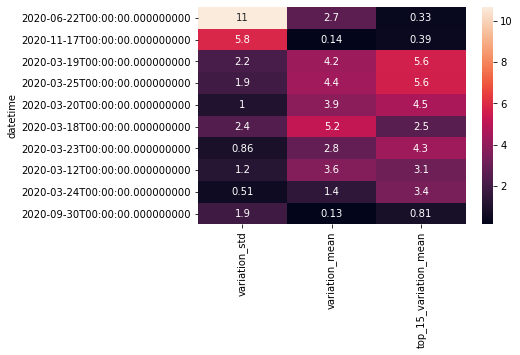

In [62]:
sns.heatmap(df_top_10_zscore_short,annot=True)